In [1]:
# load packages
import os
import requests
import zipfile
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

In [2]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Functions
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [4]:
# Custom Dataset Class
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [5]:
# Load training and validation data
dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

# Load test data
dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# Print data shapes
print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [6]:
# Creating Dataset Instances and Data Loaders

batch_size = 64
dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [7]:
# Viewing dataset_train
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.2738, 0.0020, 0.2732,  ..., 0.0163, 0.2715, 0.0103],
          [0.2738, 0.0020, 0.2733,  ..., 0.0163, 0.2714, 0.0196],
          [0.2738, 0.0020, 0.2733,  ..., 0.0163, 0.2715, 0.0103],
          ...,
          [0.2742, 0.0014, 0.2733,  ..., 0.0011, 0.2714, 0.0196],
          [0.2745, 0.0010, 0.2733,  ..., 0.0060, 0.2714, 0.0196],
          [0.2744, 0.0029, 0.2733,  ..., 0.0011, 0.2714, 0.0196]]]],
       dtype=torch.float64)
tensor([0.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layer_dim=128, p_dropout=0.5):
        super(MLP, self).__init__()

        # input_dim = (channels, height, width) = (1, 100, 40)
        flat_dims = input_dim[0] * input_dim[1] * input_dim[2]  # 1 * 100 * 40 = 4000

        self.fc1 = nn.Sequential(
            nn.Linear(flat_dims, hidden_layer_dim),
            nn.LeakyReLU(),
            nn.Dropout(p=p_dropout)
        )
        self.fc2 = nn.Linear(hidden_layer_dim, output_dim)

    def forward(self, x):
        # x.shape = [batch_size, 1, 100, 40]
        x = x.view(x.size(0), -1).float()  
        out = self.fc1(x)                 # [batch_size, hidden_layer_dim]
        out = self.fc2(out)               # [batch_size, output_dim]
        return out

In [9]:
class CNN1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        n_features = input_dim[2]

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, n_features), padding=(3, 0), dilation=(2, 1))
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=2)

        # Max pooling layers
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(26 * 32, 32)
        self.fc2 = nn.Linear(32, output_dim)

        # Activation function
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        # Apply convolutional layers with activation
        out = self.relu(self.conv1(x))                  # [batch_size, 16, H_out, W_out]
        out = out.permute(0, 1, 3, 2).reshape(out.size(0), out.size(1), -1)  # [batch_size, 16, W_out * H_out]

        out = self.relu(self.conv2(out))                # [batch_size, 16, L_out]
        out = self.maxpool1(out)                        # [batch_size, 16, L_out//2]

        out = self.relu(self.conv3(out))                # [batch_size, 32, L_out//2]
        out = self.relu(self.conv4(out))                # [batch_size, 32, L_out//2]
        out = self.maxpool2(out)                        # [batch_size, 32, L_out//4]

        # Flatten
        out = out.view(out.size(0), -1)                 # [batch_size, 32 * (L_out//4)]

        # Fully connected layers
        out = self.relu(self.fc1(out))                  # [batch_size, 32]
        out = self.fc2(out)                             # [batch_size, output_dim]

        return out

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN2, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(10, 42), padding=(0, 2))
        self.bn1 = nn.BatchNorm2d(16)
        self.prelu1 = nn.PReLU()

        # Convolution 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=10)  # kernel_size can be int
        self.bn2 = nn.BatchNorm1d(16)
        self.prelu2 = nn.PReLU()

        # Convolution 3
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8)  # kernel_size can be int
        self.bn3 = nn.BatchNorm1d(32)
        self.prelu3 = nn.PReLU()

        # Convolution 4
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=6)  # kernel_size can be int
        self.bn4 = nn.BatchNorm1d(32)
        self.prelu4 = nn.PReLU()

        # Convolution 5
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=4)  # kernel_size can be int
        self.bn5 = nn.BatchNorm1d(32)
        self.prelu5 = nn.PReLU()

        self.fc1 = nn.Linear(249 * 32, 32)
        self.prelu6 = nn.PReLU()

        # Fully connected 2
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # x.shape = [batch_size, 1, 100, 40]

        # Convolution 1
        out = self.conv1(x)  # out.shape = [batch_size, 16, 91, 2]
        out = self.bn1(out)
        out = self.prelu1(out)
        
        # Reshape for Conv1d: 将 [batch_size, 16, 91, 2] -> [batch_size, 16, 91 * 2] = [batch_size, 16, 182]
        out = out.view(out.size(0), out.size(1), -1)

        # Convolution 2
        out = self.conv2(out)  # out.shape = [batch_size, 16, 173] (182 - 10 + 1)
        out = self.bn2(out)
        out = self.prelu2(out)

        # Convolution 3
        out = self.conv3(out)  # out.shape = [batch_size, 32, 166] (173 - 8 + 1)
        out = self.bn3(out)
        out = self.prelu3(out)

        # Convolution 4
        out = self.conv4(out)  # out.shape = [batch_size, 32, 161] (166 - 6 + 1)
        out = self.bn4(out)
        out = self.prelu4(out)

        # Convolution 5
        out = self.conv5(out)  # out.shape = [batch_size, 32, 158] (161 - 4 + 1)
        out = self.bn5(out)
        out = self.prelu5(out)

        out = out.view(out.size(0), -1)  # out.shape = [batch_size, 32 * 158] = [batch_size, 5056]

        out = self.fc1(out)
        out = self.prelu6(out)

        out = self.fc2(out)  # out.shape = [batch_size, output_dim]

        return out

In [11]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [12]:
class BiN(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1
        self.d1 = d1
        self.t2 = t2
        self.d2 = d2

        bias1 = torch.Tensor(t1, 1)
        self.B1 = nn.Parameter(bias1)
        nn.init.constant_(self.B1, 0)

        l1 = torch.Tensor(t1, 1)
        self.l1 = nn.Parameter(l1)
        nn.init.xavier_normal_(self.l1)

        bias2 = torch.Tensor(d1, 1)
        self.B2 = nn.Parameter(bias2)
        nn.init.constant_(self.B2, 0)

        l2 = torch.Tensor(d1, 1)
        self.l2 = nn.Parameter(l2)
        nn.init.xavier_normal_(self.l2)

        y1 = torch.Tensor(1, )
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.5)

        y2 = torch.Tensor(1, )
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.5)

    def forward(self, x):
        if (self.y1[0] < 0):
            y1 = torch.zeros(1, ).to(x.device)
            self.y1 = nn.Parameter(y1)
            nn.init.constant_(self.y1, 0.01)

        if (self.y2[0] < 0):
            y2 = torch.zeros(1, ).to(x.device)
            self.y2 = nn.Parameter(y2)
            nn.init.constant_(self.y2, 0.01)

        T2 = torch.ones([self.t1, 1], device=x.device)
        x2 = torch.mean(x, dim=2)
        x2 = torch.reshape(x2, (x2.shape[0], x2.shape[1], 1))

        std = torch.std(x, dim=2)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))
        std[std < 1e-4] = 1

        diff = x - (x2 @ T2.T)
        Z2 = diff / (std @ T2.T)

        X2 = self.l2 @ T2.T
        X2 = X2 * Z2
        X2 = X2 + (self.B2 @ T2.T)

        T1 = torch.ones([self.d1, 1], device=x.device)
        x1 = torch.mean(x, dim=1)
        x1 = torch.reshape(x1, (x1.shape[0], x1.shape[1], 1))

        std = torch.std(x, dim=1)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

        op1 = x1 @ T1.T
        op1 = torch.permute(op1, (0, 2, 1))

        op2 = std @ T1.T
        op2 = torch.permute(op2, (0, 2, 1))

        z1 = (x - op1) / (op2)
        X1 = (T1 @ self.l1.T)
        X1 = X1 * z1
        X1 = X1 + (T1 @ self.B1.T)

        x = self.y1 * X1 + self.y2 * X2

        return x

class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1 / t1)

        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1, )
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        if (self.l[0] < 0):
            l = torch.tensor([0.0], device=X.device)
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1):
            l = torch.tensor([1.0], device=X.device)
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 1.0)

        X = self.W1 @ X

        W = self.W - self.W * torch.eye(self.t1, device=X.device) + torch.eye(self.t1, device=X.device) / self.t1

        E = X @ W

        A = torch.softmax(E, dim=-1)

        X = self.l[0] * X + (1.0 - self.l[0]) * X * A

        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.W1 @ x @ self.W2 + self.B)
        return x

class LOBCAST_model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

class BinCTABL(LOBCAST_model):
    def __init__(self, input_dim, output_dim, d2, d1, t1, t2, d3, t3, d4, t4):
        super().__init__(input_dim, output_dim)

        self.BiN = BiN(d2, d1, t1, t2)
        self.BL = BL_layer(d2, d1, t1, t2)
        self.BL2 = BL_layer(d3, d2, t2, t3)
        self.TABL = TABL_layer(d4, d3, t3, t4)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.squeeze(1)  

        # Permute to [batch_size, features, time]
        x = torch.permute(x, (0, 2, 1))  # [batch_size, 40, 100]

        x = self.BiN(x)

        # Apply max norm to BL layers
        self.max_norm_(self.BL.W1.data)
        self.max_norm_(self.BL.W2.data)
        x = self.BL(x)
        x = self.dropout(x)

        self.max_norm_(self.BL2.W1.data)
        self.max_norm_(self.BL2.W2.data)
        x = self.BL2(x)
        x = self.dropout(x)

        # Apply max norm to TABL layers
        self.max_norm_(self.TABL.W1.data)
        self.max_norm_(self.TABL.W.data)
        self.max_norm_(self.TABL.W2.data)
        x = self.TABL(x)
        x = torch.squeeze(x) 

        return x

    def max_norm_(self, w):
        with torch.no_grad():
            if (torch.linalg.matrix_norm(w) > 10.0):
                norm = torch.linalg.matrix_norm(w)
                desired = torch.clamp(norm, min=0.0, max=10.0)
                w *= (desired / (1e-8 + norm))

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Helper function for 1x1 Conv
def _conv1d1x1(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm1d(out_channels)
    )

class GatedAxialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dim, flag):
        assert (in_channels % heads == 0) and (out_channels % heads == 0)
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dim_head_v = out_channels // heads
        self.flag = flag  # if flag then we do the attention along width
        self.dim = dim
        self.dim_head_qk = self.dim_head_v // 2  # 保持 dim_head_qk = dim_head_v // 2
        self.qkv_channels = self.dim_head_v + self.dim_head_qk * 2  # 确保 qkv_channels = 2 * dim_head_qk + dim_head_v

        # Multi-head self attention
        self.to_qkv = _conv1d1x1(in_channels, self.heads * self.qkv_channels)
        self.bn_qkv = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.bn_similarity = nn.BatchNorm2d(heads * 3)
        self.bn_output = nn.BatchNorm1d(self.heads * self.qkv_channels)

        # Gating mechanism
        self.f_qr = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_kr = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.3), requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(0.5), requires_grad=False)

        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.dim_head_v * 2, dim * 2 - 1), requires_grad=True)
        query_index = torch.arange(dim).unsqueeze(0)
        key_index = torch.arange(dim).unsqueeze(1)
        relative_index = key_index - query_index + dim - 1
        self.register_buffer('flatten_index', relative_index.view(-1))

        self.reset_parameters()

    def forward(self, x):
        if self.flag:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        x = self.to_qkv(x)
        qkv = self.bn_qkv(x)
        # 修改 split sizes 为 [dim_head_qk, dim_head_qk, dim_head_v]
        q, k, v = torch.split(
            qkv.reshape(N * W, self.heads, self.qkv_channels, H),
            [self.dim_head_qk, self.dim_head_qk, self.dim_head_v],
            dim=2
        )

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.dim_head_v * 2, self.dim, self.dim)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.dim_head_qk, self.dim_head_qk, self.dim_head_v], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci,bgcj->bgij', q, k)

        # Multiply by factors
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.heads, H, H).sum(dim=1)
        similarity = torch.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

        # Multiply by factors
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)

        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_channels * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_channels, 2, H).sum(dim=-2)

        if self.flag:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        return output

    def reset_parameters(self):
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.dim_head_v))

class AxialLOB(nn.Module):
    def __init__(self, W, H, c_in, c_out, c_final, n_heads, pool_kernel, pool_stride, num_classes):
        super().__init__()

        # Channel output of the CNN_in is the channel input for the axial layer
        self.c_in = c_in
        self.c_out = c_out
        self.c_final = c_final

        self.CNN_in = nn.Conv2d(in_channels=1, out_channels=c_in, kernel_size=1)
        self.CNN_out = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res2 = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res1 = nn.Conv2d(in_channels=1, out_channels=c_out, kernel_size=1)

        self.norm = nn.BatchNorm2d(c_in)
        self.res_norm2 = nn.BatchNorm2d(c_final)
        self.res_norm1 = nn.BatchNorm2d(c_out)
        self.norm2 = nn.BatchNorm2d(c_final)
        self.axial_height_1 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_1 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.axial_height_2 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_2 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)

        self.activation = nn.ReLU(inplace=True)  # 使用 in-place 激活以减少内存

        # 减少线性层的输入大小，通过减少 c_final 和 pool stride
        self.linear = nn.Linear(c_final * (W // pool_stride[1]) * (H // pool_stride[0]), num_classes)
        self.pooling = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        # Up branch
        # First convolution before the attention
        y = self.CNN_in(x)
        y = self.norm(y)
        y = self.activation(y)

        # Attention mechanism through gated multi-head axial layers
        y = self.axial_width_1(y)
        y = self.axial_height_1(y)

        # Lower branch
        x_res = self.CNN_res1(x)
        x_res = self.res_norm1(x_res)
        x_res = self.activation(x_res)

        # First residual connection
        y = y + x_res
        z = y.detach()  # 使用 detach() 代替 clone()，以减少内存占用

        # Second axial layer
        y = self.axial_width_2(y)
        y = self.axial_height_2(y)

        # Second convolution
        y = self.CNN_out(y)
        y = self.res_norm2(y)
        y = self.activation(y)

        # Lower branch
        z = self.CNN_res2(z)
        z = self.norm2(z)
        z = self.activation(z)

        # Second residual connection
        y = y + z

        # Final part
        y = self.pooling(y)
        y = torch.flatten(y, 1)
        y = self.linear(y)
        forecast_y = torch.softmax(y, dim=1)
        return forecast_y

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [14]:
# List of model names
model_names = ['MLP', 'CNN1', 'DeepLOB', 'CNN2', 'BinCTABL', 'AxialLOB']

# Initialize dictionaries to store file paths
loss_files = {
    'train': {},
    'val': {}
}

best_model_files = {}

# Assuming all CSV and model files are in the current working directory
for model in model_names:
    loss_files['train'][model] = f'train_losses_{model}.csv'
    loss_files['val'][model] = f'val_losses_{model}.csv'
    best_model_files[model] = f'best_val_model_{model}_pytorch'

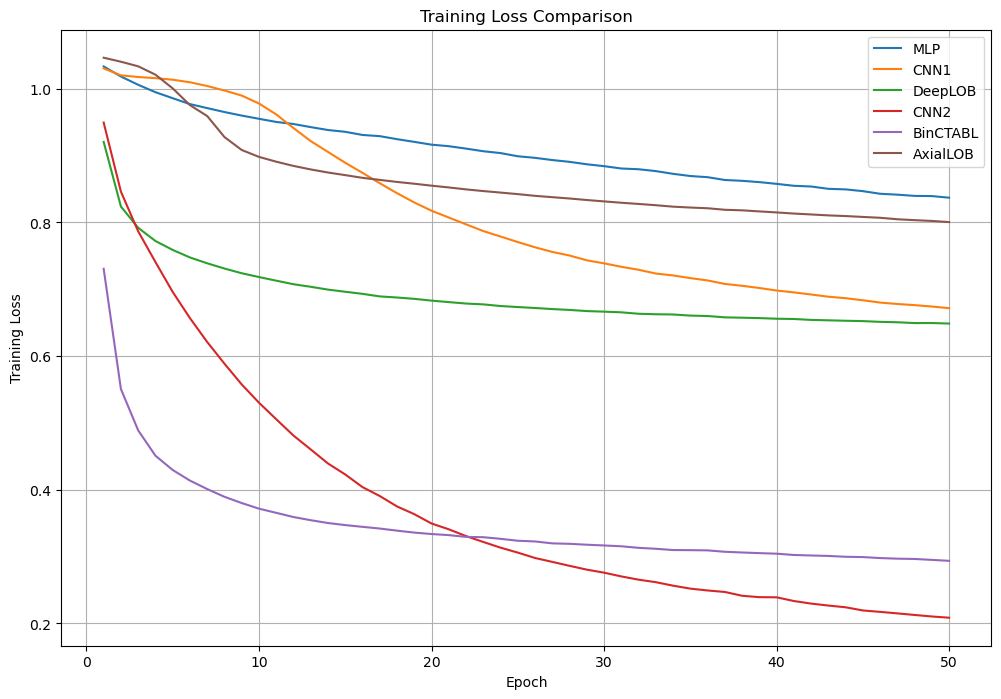

In [15]:
plt.figure(figsize=(12, 8))
for model in model_names:
    # Check if the file exists
    if os.path.isfile(loss_files['train'][model]):
        # Load training loss
        df_train = pd.read_csv(loss_files['train'][model])
        epochs = df_train['Epoch']
        train_loss = df_train['Train_Loss']
        
        # Plot training loss curve
        plt.plot(epochs, train_loss, label=model)
    else:
        print(f"Training loss file {loss_files['train'][model]} does not exist.")

plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

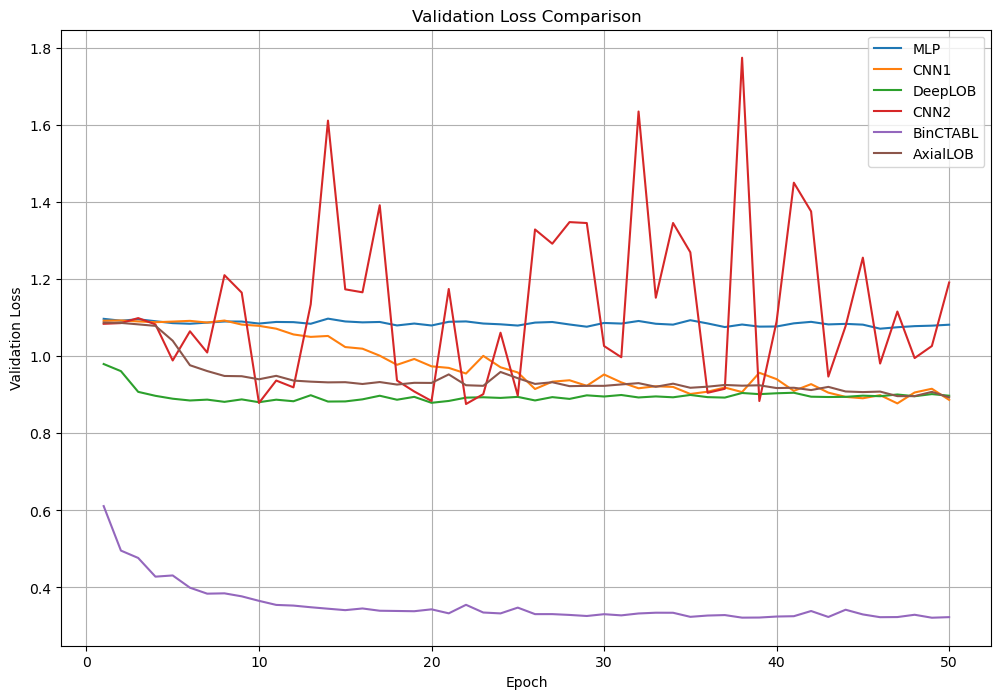

In [16]:
plt.figure(figsize=(12, 8))
for model in model_names:
    # Check if the file exists
    if os.path.isfile(loss_files['val'][model]):
        # Load validation loss
        df_val = pd.read_csv(loss_files['val'][model])
        epochs = df_val['Epoch']
        val_loss = df_val['Val_Loss']
        
        # Plot validation loss curve
        plt.plot(epochs, val_loss, label=model)
    else:
        print(f"Validation loss file {loss_files['val'][model]} does not exist.")

plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define model file list
model_files = [
    'best_val_model_AxialLOB_pytorch',
    'best_val_model_BinCTABL_pytorch',
    'best_val_model_DeepLOB_pytorch',
    'best_val_model_CNN2_pytorch',
    'best_val_model_CNN1_pytorch',
    'best_val_model_MLP_pytorch'
]

# Specify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize results list
results = []

for model_file in model_files:
    try:
        print(f"Evaluating model: {model_file}")
        
        # Load model with specified map_location
        model = torch.load(model_file, map_location=device)
        model.to(device)
        model.eval()  # Set model to evaluation mode
        
        n_correct = 0.
        n_total = 0.
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                # Move data to specified device
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
                
                # Forward pass
                outputs = model(inputs)
                
                # Get predictions
                _, predictions = torch.max(outputs, 1)
                
                # Update correct count and total count
                n_correct += (predictions == targets).sum().item()
                n_total += targets.size(0)
        
        # Calculate test accuracy
        test_acc = n_correct / n_total
        print(f"Test acc: {test_acc:.4f}")
        
        # Add result to list
        results.append({
            'Model Name': model_file,
            'Accuracy': test_acc
        })
        
    except Exception as e:
        print(f"Error evaluating model {model_file}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Format numerical display to four decimal places
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x:.4f}")

# Display result table
print("\nTest Accuracy of All Models:")
print(results_df)

In [20]:
model_files = [
    'best_val_model_AxialLOB_pytorch',
    'best_val_model_BinCTABL_pytorch',
    'best_val_model_DeepLOB_pytorch',
    'best_val_model_CNN2_pytorch',
    'best_val_model_CNN1_pytorch',
    'best_val_model_MLP_pytorch'
]

# Specify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize results list
results = []

for model_file in model_files:
    try:
        print(f"Evaluating model: {model_file}")
        
        # Load model with specified map_location
        model = torch.load(model_file, map_location=device)
        model.to(device)
        model.eval()  # Set model to evaluation mode
        
        all_targets = []
        all_predictions = []
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                # Move data to specified device
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
                
                # Forward pass
                outputs = model(inputs)
                
                # Get predictions
                _, predictions = torch.max(outputs, 1)
                
                # Collect all targets and predictions
                all_targets.append(targets.cpu().numpy())
                all_predictions.append(predictions.cpu().numpy())
        
        # Concatenate all targets and predictions
        all_targets = np.concatenate(all_targets)
        all_predictions = np.concatenate(all_predictions)
        
        # Generate classification report
        report = classification_report(all_targets, all_predictions, digits=4, output_dict=True)
        
        # Extract macro avg and weighted avg metrics
        macro_precision = report['macro avg']['precision']
        macro_recall = report['macro avg']['recall']
        macro_f1 = report['macro avg']['f1-score']
        
        weighted_precision = report['weighted avg']['precision']
        weighted_recall = report['weighted avg']['recall']
        weighted_f1 = report['weighted avg']['f1-score']
        
        # Append results to the list
        results.append({
            'Model Name': model_file,
            'Macro Precision': macro_precision,
            'Macro Recall': macro_recall,
            'Macro F1-Score': macro_f1,
            'Weighted Precision': weighted_precision,
            'Weighted Recall': weighted_recall,
            'Weighted F1-Score': weighted_f1
        })
        
        print(f"Model {model_file} evaluated successfully.\n")
        
    except Exception as e:
        print(f"Error evaluating model {model_file}: {e}\n")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Format numerical values to four decimal places
results_df['Macro Precision'] = results_df['Macro Precision'].apply(lambda x: f"{x:.4f}")
results_df['Macro Recall'] = results_df['Macro Recall'].apply(lambda x: f"{x:.4f}")
results_df['Macro F1-Score'] = results_df['Macro F1-Score'].apply(lambda x: f"{x:.4f}")
results_df['Weighted Precision'] = results_df['Weighted Precision'].apply(lambda x: f"{x:.4f}")
results_df['Weighted Recall'] = results_df['Weighted Recall'].apply(lambda x: f"{x:.4f}")
results_df['Weighted F1-Score'] = results_df['Weighted F1-Score'].apply(lambda x: f"{x:.4f}")

# Display the result table
print("\nTest Results for All Models:")
print(results_df)

Using device: cpu
Evaluating model: best_val_model_AxialLOB_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_AxialLOB_pytorch evaluated successfully.

Evaluating model: best_val_model_BinCTABL_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_BinCTABL_pytorch evaluated successfully.

Evaluating model: best_val_model_DeepLOB_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_DeepLOB_pytorch evaluated successfully.

Evaluating model: best_val_model_CNN2_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_CNN2_pytorch evaluated successfully.

Evaluating model: best_val_model_CNN1_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_CNN1_pytorch evaluated successfully.

Evaluating model: best_val_model_MLP_pytorch


C:\Users\liujunyuan\AppData\Local\Temp\ipykernel_24424\1426667508.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Model best_val_model_MLP_pytorch evaluated successfully.


Test Results for All Models:
                        Model Name Macro Precision Macro Recall  \
0  best_val_model_AxialLOB_pytorch          0.6864       0.6810   
1  best_val_model_BinCTABL_pytorch          0.8195       0.8201   
2   best_val_model_DeepLOB_pytorch          0.7419       0.7391   
3      best_val_model_CNN2_pytorch          0.6019       0.5973   
4      best_val_model_CNN1_pytorch          0.6556       0.6503   
5       best_val_model_MLP_pytorch          0.4974       0.4754   

  Macro F1-Score Weighted Precision Weighted Recall Weighted F1-Score  
0         0.6797             0.6898          0.6799            0.6810  
1         0.8197             0.8196          0.8197            0.8196  
2         0.7397             0.7426          0.7397            0.7403  
3         0.5952             0.6028          0.5965            0.5951  
4         0.6503             0.6577          0.6495            0.6510  
5         